# Projeto 11: Rede Neural Convolucional MNIST

## Etapa 1: Importação das bibliotecas

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

from torch import optim


## Etapa 2: Base de dados

In [3]:
torch.manual_seed(123)

In [4]:
transform = transforms.ToTensor()

In [5]:
X = datasets.MNIST(root = '.', train=True, download=True, transform=transform)
y = datasets.MNIST(root = '.', train=False, download=True, transform=transform)

In [6]:
X.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [7]:
X.data.shape

torch.Size([60000, 28, 28])

In [8]:
X.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
train_loader = torch.utils.data.DataLoader(X, batch_size=128)
test_loader = torch.utils.data.DataLoader(y, batch_size=128)

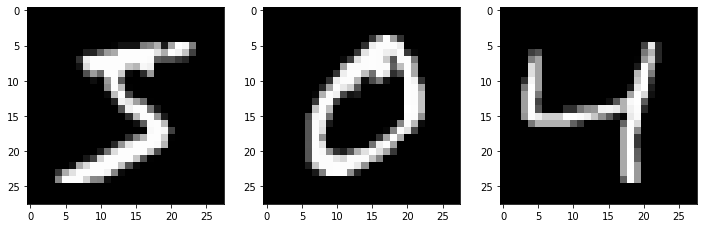

In [10]:
_, ax = plt.subplots(1,3, figsize=(12,5))
for i in range(3):
  img = next(iter(train_loader))[0][i].view(28,28)
  ax[i].imshow(img, cmap='gray')
plt.show()

In [11]:
img.shape

torch.Size([28, 28])

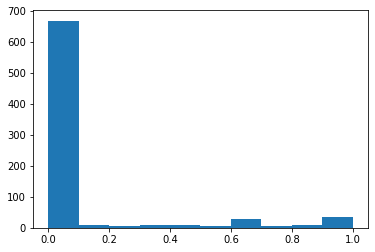

In [12]:
plt.hist(img.view(-1));

## Etapa 3: Construção do modelo

In [17]:
class cls_torch(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32,32,(3,3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.flatten = nn.Flatten()
    
    # output = (input - filter + 1) / stride
    # Convolução 1: (28 - 3 + 1) / 1 = 26 => img(26px X 26px)
    # Pooling 1: kernel_size=(2,2) => 26 / 2, 26 / 2 => img(13px X 13px)
    # Convolução 2: (13 - 3 + 1) / 1 = 11 => img(11px X 11px)
    # Pooling 2: kernel_size=(2,2) => 11 / 2, 11 / 2 => img(5px X 5px)
    # Saída Pooling 2 = 5 * 5 * 32 (BatchNorm2d(num_features=32))
    # 800 -> 128

    self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)
    return X

In [18]:
net = cls_torch()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Etapa 4: Treinamento do modelo

In [19]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [20]:
net.to(device)

cls_torch(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [26]:
def training_loop(loader, epoch):
  running_loss = 0.
  running_acc = 0.

  for i, data in enumerate(loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()
    running_loss += loss.item()

    ps = F.softmax(outputs)
    top_p, top_class = ps.topk(k = 1, dim = 1)
    equals = top_class == labels.view(*top_class.shape)

    acc = torch.mean(equals.type(torch.float))
    running_acc += acc

    # Imprimindo os resultados referentes a este loop
    #print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}' \
    #      .format(epoch + 1, i + 1, len(loader), loss, acc, end = '\r'))
    
  # Imprimindo os dados referentes a esta época
  print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}\n' \
        .format(epoch + 1, running_loss / len(loader), running_acc / len(loader)))

In [27]:
for epoch in range(5):
  print('Treinando...')
  training_loop(train_loader, epoch)
  net.eval()
  print('Validando...')
  training_loop(test_loader, epoch)
  net.train()

Treinando...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ÉPOCA   1 FINALIZADA: perda 0.01307 - precisão 0.99611

Validando...
ÉPOCA   1 FINALIZADA: perda 0.01402 - precisão 0.99545

Treinando...
ÉPOCA   2 FINALIZADA: perda 0.01367 - precisão 0.99590

Validando...
ÉPOCA   2 FINALIZADA: perda 0.01156 - precisão 0.99634

Treinando...
ÉPOCA   3 FINALIZADA: perda 0.01137 - precisão 0.99673

Validando...
ÉPOCA   3 FINALIZADA: perda 0.01130 - precisão 0.99614

Treinando...
ÉPOCA   4 FINALIZADA: perda 0.01142 - precisão 0.99656

Validando...
ÉPOCA   4 FINALIZADA: perda 0.00715 - precisão 0.99753

Treinando...
ÉPOCA   5 FINALIZADA: perda 0.01428 - precisão 0.99568

Validando...
ÉPOCA   5 FINALIZADA: perda 0.00680 - precisão 0.99802



## Etapa 5: Avaliação do modelo

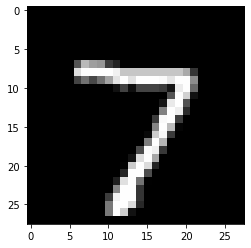

In [28]:
img = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(img, cmap='gray');

In [29]:
# (1, 1, 28, 28) => (batch_size, num_channels, height, width)
img.shape

torch.Size([28, 28])

In [30]:
img = img.view(1,1,28,28)
img.shape

torch.Size([1, 1, 28, 28])

In [31]:
net.eval()
img = img.to(device)
previsao = net.forward(img)
previsao

tensor([[ -9.0107,  -3.1641,  -4.2922,  -4.8455,  -3.1538, -10.9944, -14.6061,
          13.2390,  -9.3160,  -0.8715]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [32]:
previsao = F.softmax(previsao)
previsao

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[2.1730e-10, 7.5200e-08, 2.4339e-08, 1.3996e-08, 7.5980e-08, 2.9893e-11,
         8.0725e-13, 1.0000e+00, 1.6013e-10, 7.4455e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [33]:
previsao = previsao.cpu().detach().numpy()

In [34]:
previsao

array([[2.1729930e-10, 7.5200241e-08, 2.4339364e-08, 1.3995756e-08,
        7.5980083e-08, 2.9892637e-11, 8.0724663e-13, 9.9999905e-01,
        1.6012931e-10, 7.4454556e-07]], dtype=float32)

In [35]:
resultado = np.argmax(previsao)
resultado

7